In [2]:
import pandas as pd
df_hosp = pd.read_csv("Hospitalisation details.csv")
df_med = pd.read_csv("Medical Examinations.csv")
df_name = pd.read_excel("Names.xlsx")
# Merging the files
df = df_hosp.merge(df_med,on ='Customer ID').merge(df_name,on = 'Customer ID')

In [3]:
# Find missing and trivial values
df.isnull().sum()

Customer ID               0
year                      0
month                     0
date                      0
children                  0
charges                   0
Hospital tier             0
City tier                 0
State ID                  0
BMI                       0
HBA1C                     0
Heart Issues              0
Any Transplants           0
Cancer history            0
NumberOfMajorSurgeries    0
smoker                    0
name                      0
dtype: int64

In [4]:
(df== '?').sum()
# Count rows with any '?' in them
trivial_rows = df[df.isin(['?']).any(axis=1)]
print(f"Total rows with trivial '?' values: {len(trivial_rows)}")


Total rows with trivial '?' values: 10


In [5]:
# Deleting rows with trivial value
df = df[df.apply(lambda row: '?' not in row.values,axis = 1)]
# Let us now reset the index
df= df.reset_index(drop=True)
print("Rows left after cleaning:", df.shape[0])

Rows left after cleaning: 2325


In [ ]:
# Converting hospital and city tier into ordinal values
tier_mapping = {'Tier-1': 1, 'Tier-2': 2, 'Tier-3': 3}
df['Hospital tier'] = df['Hospital tier'].map(tier_mapping)
df['City tier'] = df['City tier'].map(tier_mapping)
# Encoding binary categorical in yes/no
binary_cols = ['Heart Issues', 'Any Transplants', 'Cancer history', 'smoker']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0, 'yes': 1, 'no': 0})
# Coverting stateid to dummyvariable

df['State_R1011'] = (df['State ID'] == 'R1011').astype(int)
df['State_R1012'] = (df['State ID'] == 'R1012').astype(int)
df['State_R1013'] = (df['State ID'] == 'R1013').astype(int)

In [7]:
df.head()
df.dtypes

Customer ID                object
year                       object
month                      object
date                        int64
children                    int64
charges                   float64
Hospital tier             float64
City tier                 float64
State ID                   object
BMI                       float64
HBA1C                     float64
Heart Issues                int64
Any Transplants             int64
Cancer history              int64
NumberOfMajorSurgeries     object
smoker                      int64
name                       object
State_R1011                 int64
State_R1012                 int64
State_R1013                 int64
dtype: object

In [8]:
# Check unique values to find weird strings
print(df['NumberOfMajorSurgeries'].unique())

['1' 'No major surgery' '2' '3']


In [9]:
# Replace 'No major surgery' with 0 and convert the column to integer
df['NumberOfMajorSurgeries'] = df['NumberOfMajorSurgeries'].replace('No major surgery', 0)

# Convert column to numeric (in case some values are still strings)
df['NumberOfMajorSurgeries'] = pd.to_numeric(df['NumberOfMajorSurgeries'])

# Check unique values to confirm cleaning
print(df['NumberOfMajorSurgeries'].unique())


[1 0 2 3]


In [10]:
print(df['year'].unique())
print(df['month'].unique())


['1992' '1993' '1998' '2001' '1995' '2002' '1997' '1999' '1996' '2004'
 '2000' '1994' '2003' '1989' '1991' '1988' '1990' '1987' '1986' '1981'
 '1985' '1984' '1983' '1982' '1980' '1979' '1977' '1978' '1974' '1973'
 '1972' '1975' '1971' '1970' '1969' '1976' '1968' '1966' '1965' '1967'
 '1962' '1963' '1964' '1961' '1960' '1959' '1958']
['Jul' 'Nov' 'Jun' 'Sep' 'Dec' 'Aug' 'Oct']


In [11]:
import pandas as pd
from datetime import datetime

# Create a mapping from month abbreviation to number
month_map = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

# Map months to numbers
df['month_num'] = df['month'].map(month_map)

# Combine into a single date of birth column (assume day = 15)
df['dob'] = pd.to_datetime(dict(year=df['year'].astype(int), 
                                month=df['month_num'], 
                                day=15), errors='coerce')

# Calculate age using a reference date (e.g., Jan 1, 2025)
reference_date = pd.to_datetime('2025-01-01')
df['age'] = (reference_date - df['dob']).dt.days // 365


In [12]:
print(df['age'].describe())


count    2325.000000
mean       41.243011
std        13.371684
min        20.000000
25%        30.000000
50%        41.000000
75%        53.000000
max        66.000000
Name: age, dtype: float64


In [13]:
# Define a function to extract gender based on salutation
def extract_gender(name):
    if pd.isnull(name):
        return 'Unknown'
    name = name.lower()
    if 'mr.' in name:
        return 'Male'
    elif 'ms.' in name or 'mrs.' in name:
        return 'Female'
    elif 'dr.' in name:
        return 'Unknown'  # could be either
    else:
        return 'Unknown'

# Apply the function to create a new 'gender' column
df['gender'] = df['name'].apply(extract_gender)

# Check gender distribution
print(df['gender'].value_counts())


gender
Female    1165
Male      1160
Name: count, dtype: int64


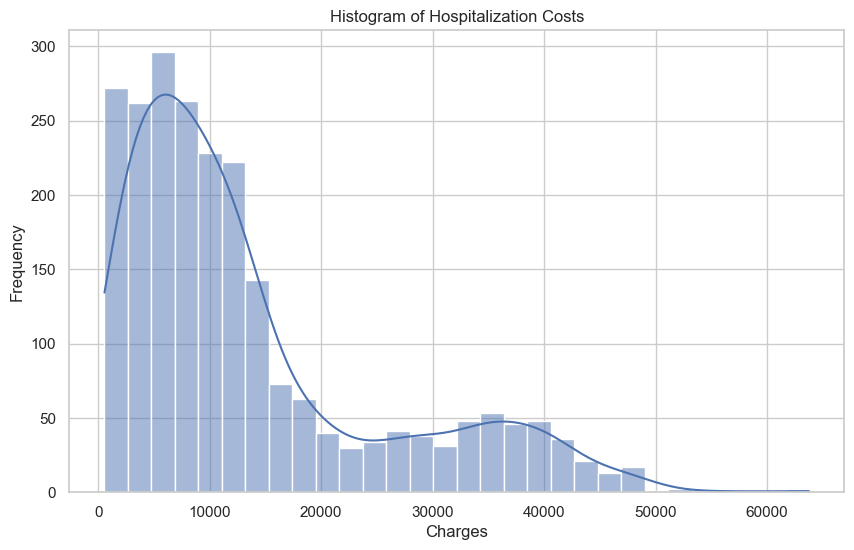

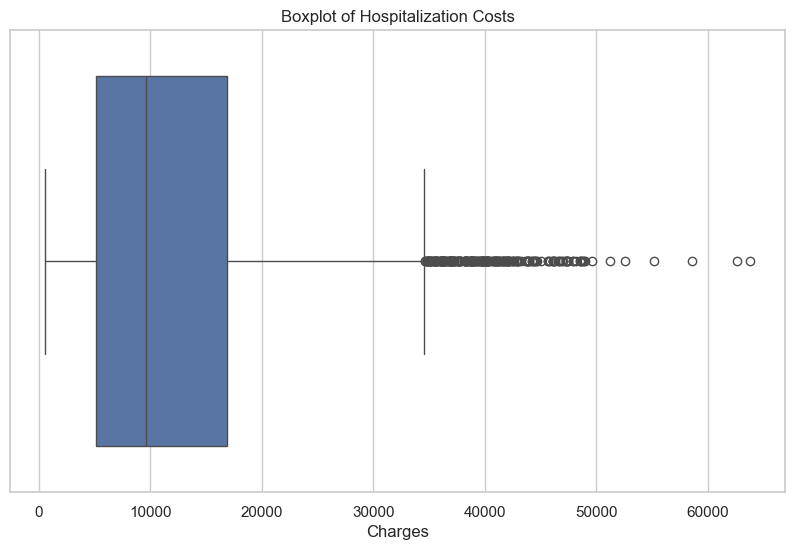

c:\Users\adity\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 17.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\adity\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 21.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


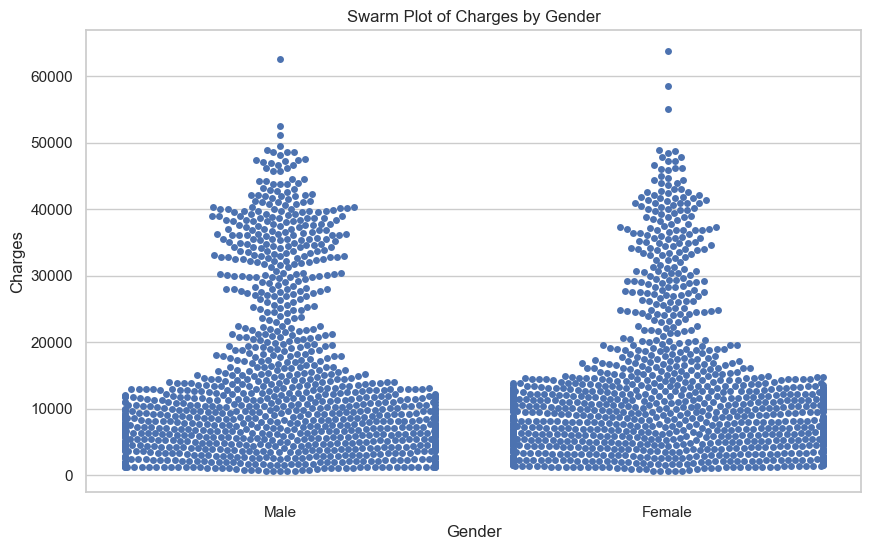

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
sns.set(style="whitegrid")

# 1. Histogram of hospitalization costs
plt.figure(figsize=(10, 6))
sns.histplot(df['charges'], bins=30, kde=True)
plt.title("Histogram of Hospitalization Costs")
plt.xlabel("Charges")
plt.ylabel("Frequency")
plt.show()

# 2. Boxplot of hospitalization costs
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['charges'])
plt.title("Boxplot of Hospitalization Costs")
plt.xlabel("Charges")
plt.show()

# 3. Swarm plot of charges by gender
plt.figure(figsize=(10, 6))
sns.swarmplot(x='gender', y='charges', data=df)
plt.title("Swarm Plot of Charges by Gender")
plt.xlabel("Gender")
plt.ylabel("Charges")
plt.show()


Step 10: State how the distribution is different across gender and tiers of hospitals

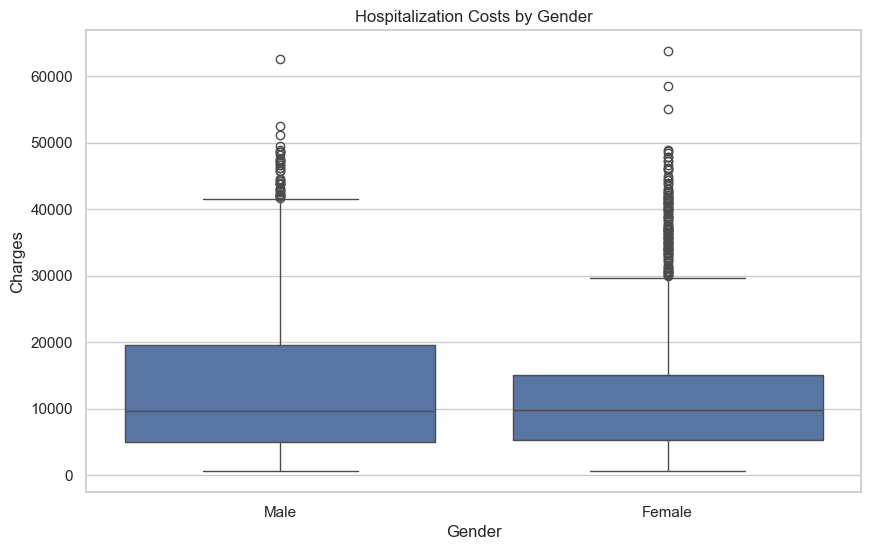

In [15]:
# BoxPlotchanges by gender

plt.figure(figsize=(10, 6))
sns.boxplot(x='gender', y='charges', data=df)
plt.title("Hospitalization Costs by Gender")
plt.xlabel("Gender")
plt.ylabel("Charges")
plt.show()


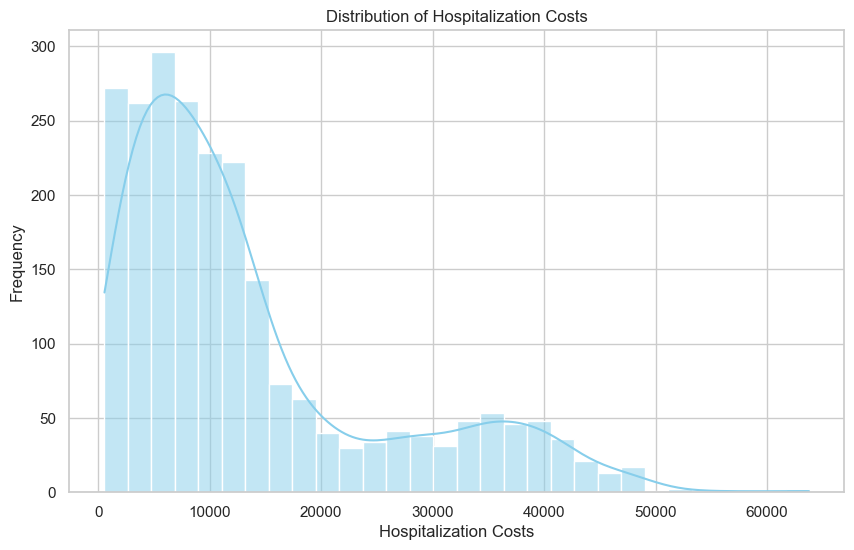

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['charges'], kde=True, bins=30, color='skyblue')
plt.title("Distribution of Hospitalization Costs")
plt.xlabel("Hospitalization Costs")
plt.ylabel("Frequency")
plt.show()


In [17]:
df.drop(columns=['City tier'], inplace=True)
# Unwanted column not keeping it

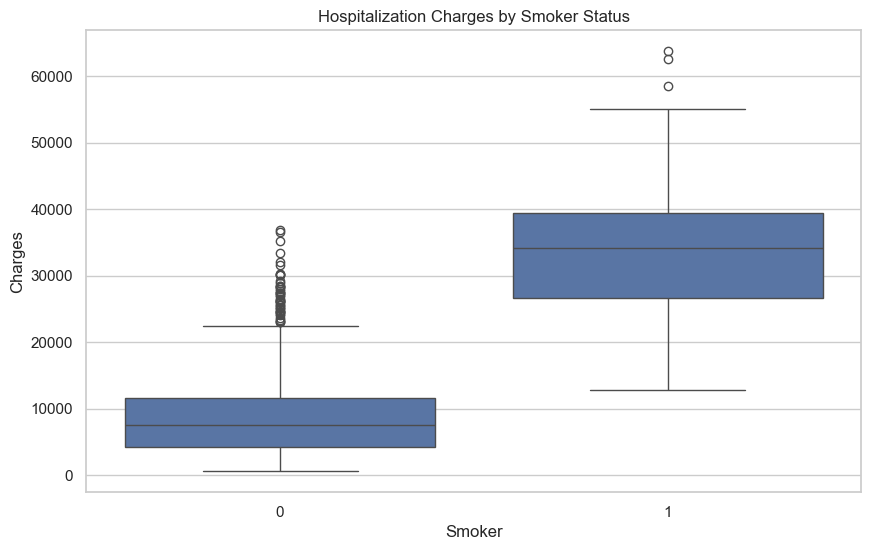

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='smoker', y='charges', data=df)
plt.title("Hospitalization Charges by Smoker Status")
plt.xlabel("Smoker")
plt.ylabel("Charges")
plt.show()


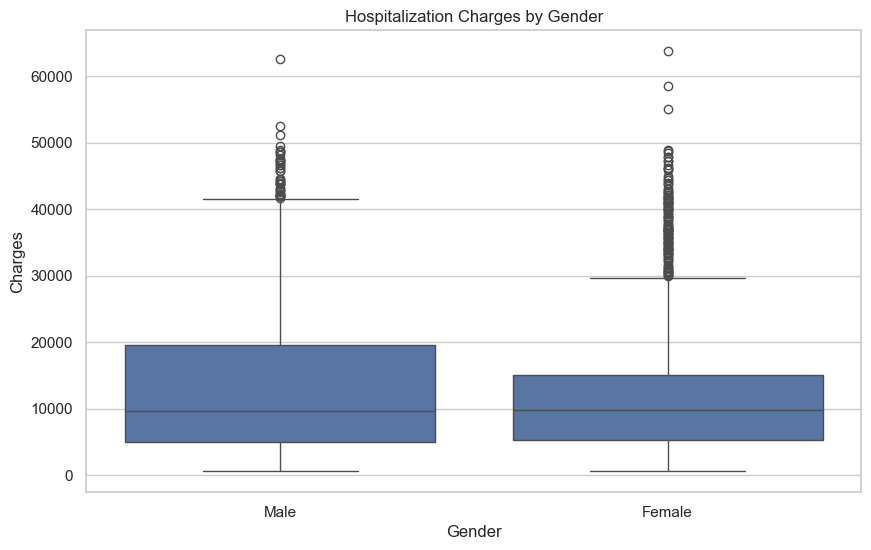

In [19]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='gender', y='charges', data=df)
plt.title("Hospitalization Charges by Gender")
plt.xlabel("Gender")
plt.ylabel("Charges")
plt.show()


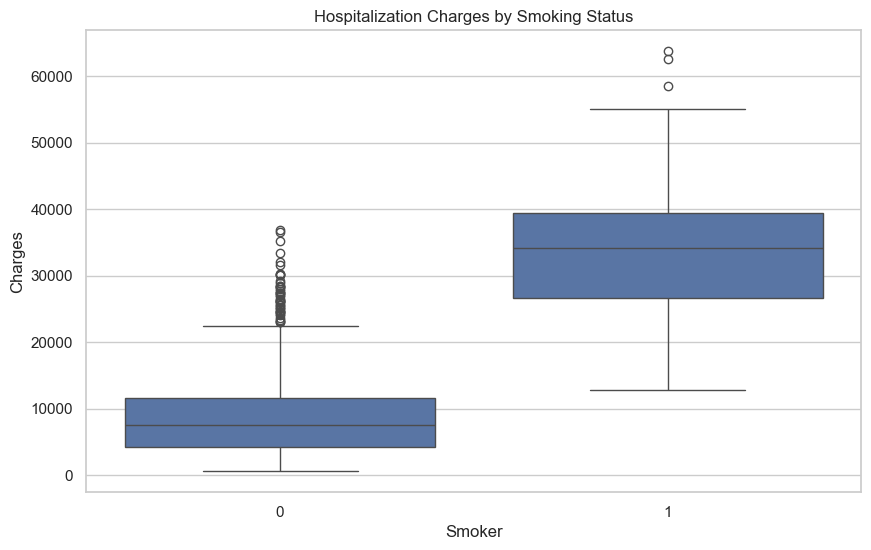

In [20]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='smoker', y='charges', data=df)
plt.title("Hospitalization Charges by Smoking Status")
plt.xlabel("Smoker")
plt.ylabel("Charges")
plt.show()


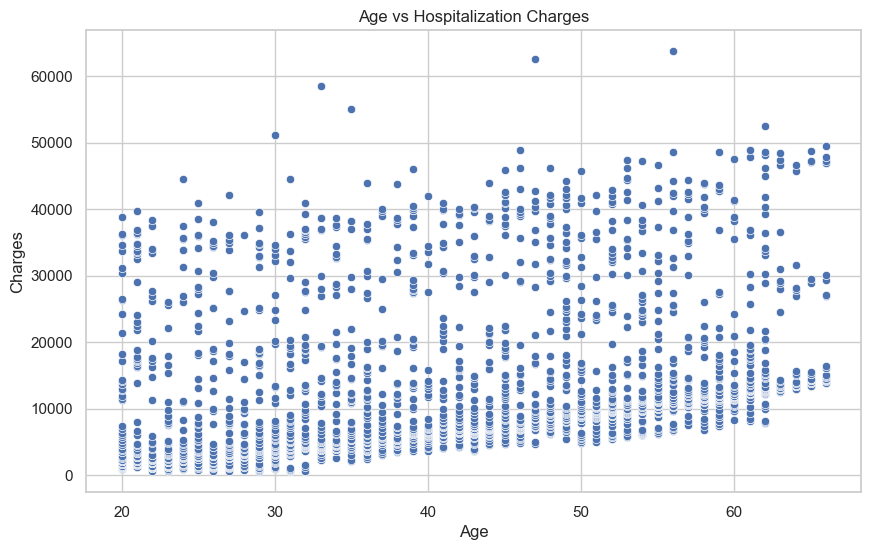

In [21]:
# Age vs charges

plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='charges', data=df)
plt.title("Age vs Hospitalization Charges")
plt.xlabel("Age")
plt.ylabel("Charges")
plt.show()


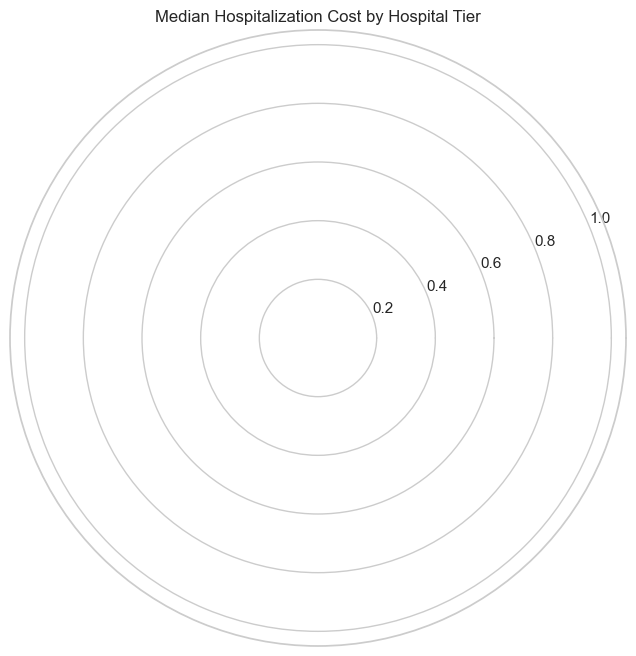

In [23]:
import numpy as np

# Prepare data
median_costs = df.groupby('Hospital tier')['charges'].median().reset_index()
labels = median_costs['Hospital tier'].astype(str).tolist()
values = median_costs['charges'].tolist()

# Close the plot
labels += labels[:1]
values += values[:1]

# Radar chart
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
ax.plot(angles, values, linewidth=1, linestyle='solid')
ax.fill(angles, values, alpha=0.4)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
plt.title("Median Hospitalization Cost by Hospital Tier")
plt.show()


In [25]:
# Stacked Bar chart Tier vs Hospital 
freq_table = pd.crosstab(df['City tier'], df['Hospital tier'])
print(freq_table)

freq_table.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')
plt.title("Distribution of Patients by City and Hospital Tier")
plt.xlabel("City Tier")
plt.ylabel("Number of Patients")
plt.legend(title="Hospital Tier")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


KeyError: 'City tier'

In [26]:
print(df.columns.tolist())


['Customer ID', 'year', 'month', 'date', 'children', 'charges', 'Hospital tier', 'State ID', 'BMI', 'HBA1C', 'Heart Issues', 'Any Transplants', 'Cancer history', 'NumberOfMajorSurgeries', 'smoker', 'name', 'State_R1011', 'State_R1012', 'State_R1013', 'month_num', 'dob', 'age', 'gender']


In [33]:
from scipy import stats

# Filter smoker and non-smoker charges using correct values
smoker_charges = df[df['smoker'] == 1]['charges']
nonsmoker_charges = df[df['smoker'] == 0]['charges']

print("Number of smokers:", smoker_charges.shape[0])
print("Number of non-smokers:", nonsmoker_charges.shape[0])

# Perform independent t-test
t_stat, p_value = stats.ttest_ind(smoker_charges, nonsmoker_charges, equal_var=False)

print("T-test for Smokers vs Non-Smokers (Charges):")
print("T-statistic:", t_stat)
print("P-value:", p_value)

# Interpretation
if p_value < 0.05:
    print("→ Reject null hypothesis: There *is* a significant difference in charges.")
else:
    print("→ Fail to reject null hypothesis: No significant difference in charges.")


Number of smokers: 486
Number of non-smokers: 1839
T-test for Smokers vs Non-Smokers (Charges):
T-statistic: 56.316832285932286
P-value: 6.697431845033993e-238
→ Reject null hypothesis: There *is* a significant difference in charges.


In [32]:
print(df['smoker'].unique())



[0 1]


In [34]:
print(df['gender'].unique())


['Male' 'Female']


In [35]:
from scipy import stats

# Separate charges by gender
male_charges = df[df['gender'] == 'Male']['charges'].dropna()
female_charges = df[df['gender'] == 'Female']['charges'].dropna()

# Perform independent t-test
t_stat, p_value = stats.ttest_ind(male_charges, female_charges, equal_var=False)

# Print results
print("T-test for Male vs Female (Charges):")
print("T-statistic:", t_stat)
print("P-value:", p_value)

# Interpretation
if p_value < 0.05:
    print("→ Reject null hypothesis: There is a significant difference in charges between males and females.")
else:
    print("→ Fail to reject null hypothesis: No significant difference in charges between males and females.")


T-test for Male vs Female (Charges):
T-statistic: 2.9037971471599566
P-value: 0.0037221256492097504
→ Reject null hypothesis: There is a significant difference in charges between males and females.


In [36]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table for smoker and heart issues
contingency_table = pd.crosstab(df['smoker'], df['Heart Issues'])

# Display the table
print("Contingency Table:")
print(contingency_table)

# Perform Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print results
print("\nChi-square test between Smoking and Heart Issues:")
print(f"Chi2 Statistic: {chi2}")
print(f"P-value: {p}")

# Interpretation
if p < 0.05:
    print("→ Reject null hypothesis: Smoking and heart issues are dependent.")
else:
    print("→ Fail to reject null hypothesis: Smoking and heart issues are independent.")


Contingency Table:
Heart Issues     0    1
smoker                 
0             1108  731
1              297  189

Chi-square test between Smoking and Heart Issues:
Chi2 Statistic: 0.08588150449910657
P-value: 0.7694797581780767
→ Fail to reject null hypothesis: Smoking and heart issues are independent.


R² Score: 0.1202
Root Mean Squared Error: 11125.15


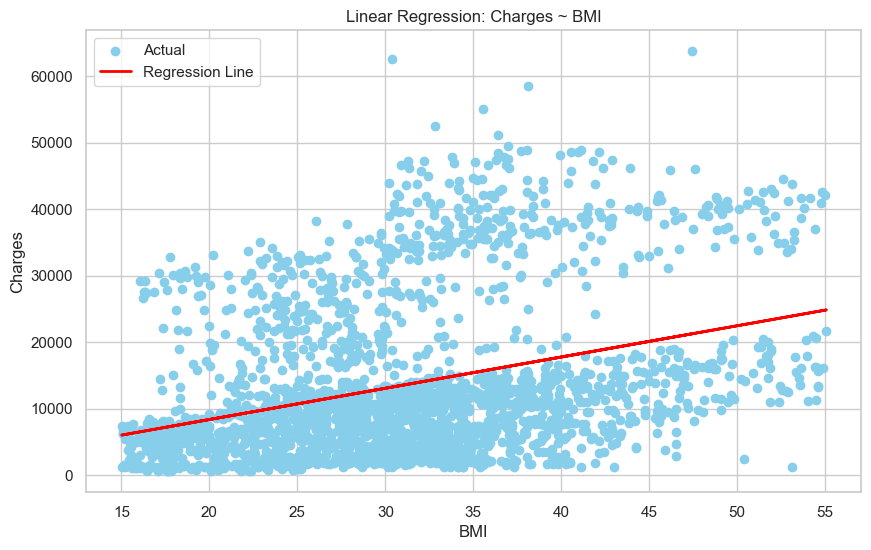

In [38]:
# Step 1: Import libraries
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

# Step 2: Drop rows with missing values in 'charges' or 'BMI'
df_lr = df[['BMI', 'charges']].dropna()

# Step 3: Split X and y
X = df_lr[['BMI']]
y = df_lr['charges']

# Step 4: Train the model
model = LinearRegression()
model.fit(X, y)

# Step 5: Predictions
y_pred = model.predict(X)

# Step 6: Evaluation
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print(f"R² Score: {r2:.4f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

# Step 7: Plot
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='skyblue', label='Actual')
plt.plot(X, y_pred, color='red', linewidth=2, label='Regression Line')
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.title('Linear Regression: Charges ~ BMI')
plt.legend()
plt.grid(True)
plt.show()


Multiple Linear Regression R² Score: 0.2065
Multiple Linear Regression Root Mean Squared Error: 10565.67


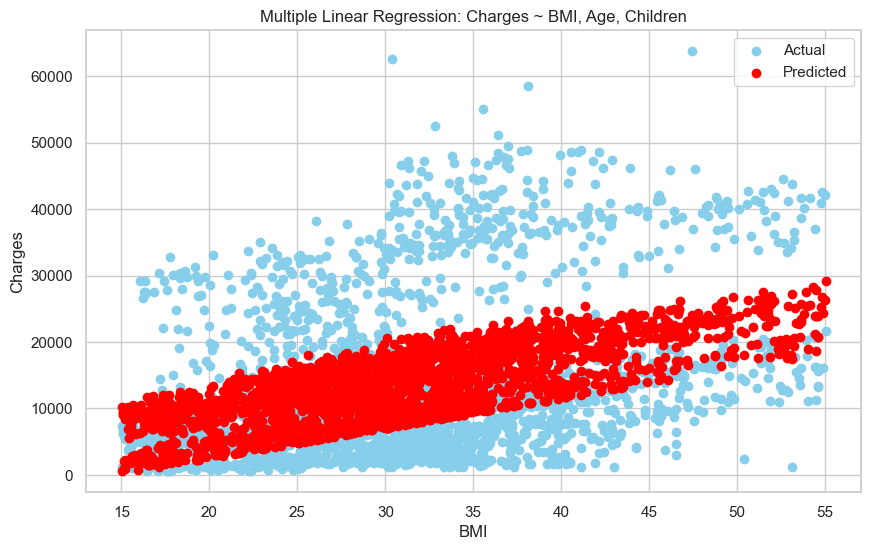

In [ ]:
# Multiple Linear Regresssion
# Step 1: Import libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# Step 2: Drop rows with missing values in 'charges', 'BMI', 'age', and 'children'
df_lr_multi = df[['BMI', 'age', 'children', 'charges']].dropna()
# Step 3: Split X and y
X_multi = df_lr_multi[['BMI', 'age', 'children']]
y_multi = df_lr_multi['charges']
# Step 4: Train the model
model_multi = LinearRegression()
model_multi.fit(X_multi, y_multi)
# Step 5: Predictions
y_pred_multi = model_multi.predict(X_multi)
# Step 6: Evaluation
r2_multi = r2_score(y_multi, y_pred_multi)
rmse_multi = np.sqrt(mean_squared_error(y_multi, y_pred_multi))
print(f"Multiple Linear Regression R² Score: {r2_multi:.4f}")
print(f"Multiple Linear Regression Root Mean Squared Error: {rmse_multi:.2f}")
# Step 7: Visualizing (for 2D, we'll plot BMI vs charges and include predictions)
plt.figure(figsize=(10, 6))
plt.scatter(df_lr_multi['BMI'], df_lr_multi['charges'], color='skyblue', label='Actual')
plt.scatter(df_lr_multi['BMI'], y_pred_multi, color='red', label='Predicted')
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.title('Multiple Linear Regression: Charges ~ BMI, Age, Children')
plt.legend()
plt.grid(True)
plt.show()


Ridge Regression R² Score: 0.2065
Ridge Regression Root Mean Squared Error: 10565.67


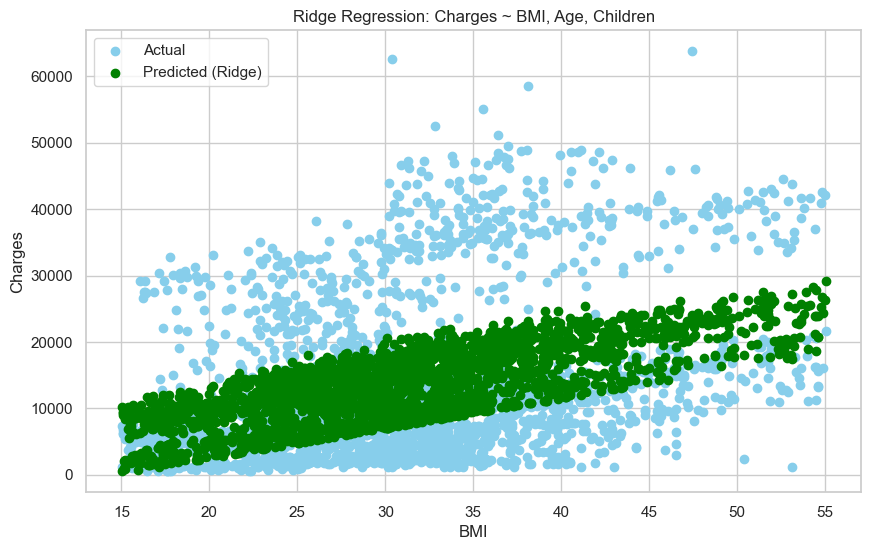

In [40]:
# Step 1: Import Ridge Regression
from sklearn.linear_model import Ridge

# Step 2: Ridge Regression model with regularization
ridge_model = Ridge(alpha=1.0)  # You can change alpha to try different levels of regularization
ridge_model.fit(X_multi, y_multi)

# Step 3: Predictions
y_pred_ridge = ridge_model.predict(X_multi)

# Step 4: Evaluation
r2_ridge = r2_score(y_multi, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_multi, y_pred_ridge))

print(f"Ridge Regression R² Score: {r2_ridge:.4f}")
print(f"Ridge Regression Root Mean Squared Error: {rmse_ridge:.2f}")

# Step 5: Visualizing (for 2D, we'll plot BMI vs charges and include predictions)
plt.figure(figsize=(10, 6))
plt.scatter(df_lr_multi['BMI'], df_lr_multi['charges'], color='skyblue', label='Actual')
plt.scatter(df_lr_multi['BMI'], y_pred_ridge, color='green', label='Predicted (Ridge)')
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.title('Ridge Regression: Charges ~ BMI, Age, Children')
plt.legend()
plt.grid(True)
plt.show()


Gradient Boosting R² Score: 0.3193
Gradient Boosting Root Mean Squared Error: 9785.81


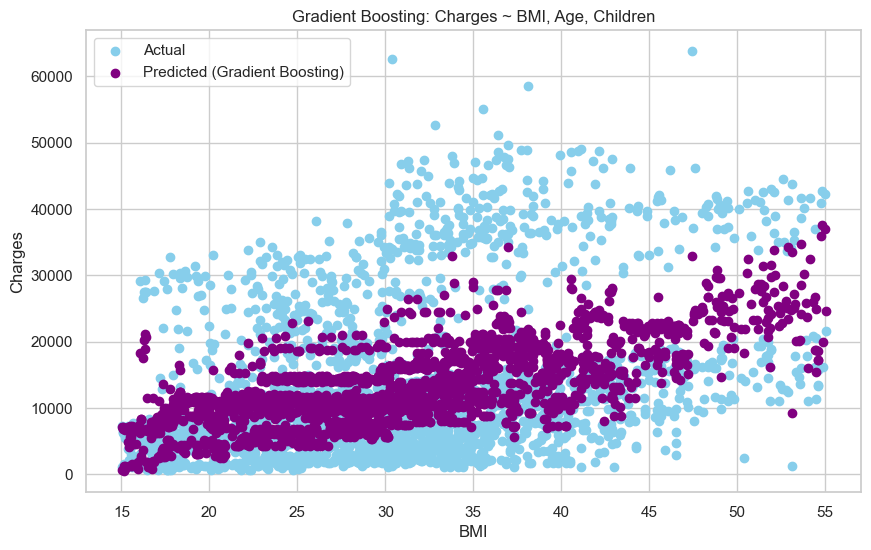

In [41]:
# Step 1: Import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Step 2: Train Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
gb_model.fit(X_multi, y_multi)

# Step 3: Predictions
y_pred_gb = gb_model.predict(X_multi)

# Step 4: Evaluation
r2_gb = r2_score(y_multi, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_multi, y_pred_gb))

print(f"Gradient Boosting R² Score: {r2_gb:.4f}")
print(f"Gradient Boosting Root Mean Squared Error: {rmse_gb:.2f}")

# Step 5: Visualizing (for 2D, we'll plot BMI vs charges and include predictions)
plt.figure(figsize=(10, 6))
plt.scatter(df_lr_multi['BMI'], df_lr_multi['charges'], color='skyblue', label='Actual')
plt.scatter(df_lr_multi['BMI'], y_pred_gb, color='purple', label='Predicted (Gradient Boosting)')
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.title('Gradient Boosting: Charges ~ BMI, Age, Children')
plt.legend()
plt.grid(True)
plt.show()


Gradient Boosting R² Score: 0.3193
Gradient Boosting Root Mean Squared Error: 9785.81


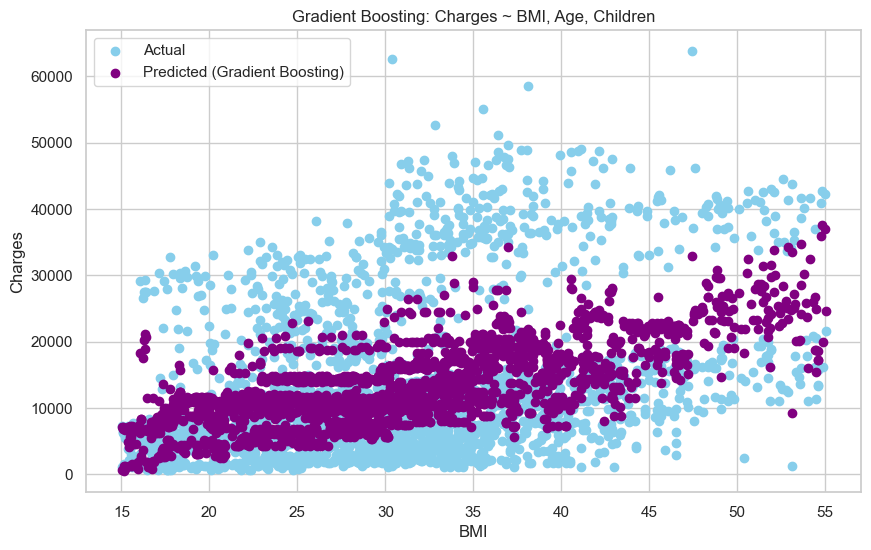

In [42]:
# Step 1: Import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Step 2: Train Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
gb_model.fit(X_multi, y_multi)

# Step 3: Predictions
y_pred_gb = gb_model.predict(X_multi)

# Step 4: Evaluation
r2_gb = r2_score(y_multi, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_multi, y_pred_gb))

print(f"Gradient Boosting R² Score: {r2_gb:.4f}")
print(f"Gradient Boosting Root Mean Squared Error: {rmse_gb:.2f}")

# Step 5: Visualizing (for 2D, we'll plot BMI vs charges and include predictions)
plt.figure(figsize=(10, 6))
plt.scatter(df_lr_multi['BMI'], df_lr_multi['charges'], color='skyblue', label='Actual')
plt.scatter(df_lr_multi['BMI'], y_pred_gb, color='purple', label='Predicted (Gradient Boosting)')
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.title('Gradient Boosting: Charges ~ BMI, Age, Children')
plt.legend()
plt.grid(True)
plt.show()


Model Comparison:
Linear Regression R²: 0.1202, RMSE: 11125.15
Ridge Regression R²: 0.2065, RMSE: 10565.67
Gradient Boosting R²: 0.3193, RMSE: 9785.81


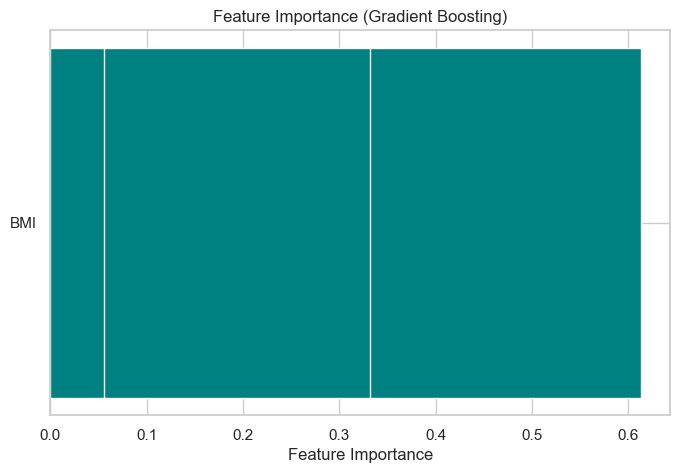

In [44]:
# Step 1: Model Comparison
print("Model Comparison:")
print(f"Linear Regression R²: {r2:.4f}, RMSE: {rmse:.2f}")
print(f"Ridge Regression R²: {r2_ridge:.4f}, RMSE: {rmse_ridge:.2f}")
print(f"Gradient Boosting R²: {r2_gb:.4f}, RMSE: {rmse_gb:.2f}")

# Step 2: Feature Importance from Gradient Boosting
feature_importance = gb_model.feature_importances_

# Step 3: Visualize Feature Importance

plt.figure(figsize=(8, 5))
plt.barh(['BMI'], feature_importance, color='teal')
plt.xlabel('Feature Importance')
plt.title('Feature Importance (Gradient Boosting)')
plt.show()



In [45]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

# Step 1: Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Gradient Boosting': GradientBoostingRegressor()
}

# Step 2: Perform cross-validation and calculate performance metrics
for model_name, model in models.items():
    print(f"\nEvaluating {model_name}:")

    # Cross-validation for R² score
    r2_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    print(f"R² Score (cross-validation): Mean = {r2_scores.mean():.4f}, Std = {r2_scores.std():.4f}")

    # Cross-validation for RMSE (negative because cross_val_score maximizes score)
    rmse_scores = cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error')
    print(f"RMSE (cross-validation): Mean = {-rmse_scores.mean():.2f}, Std = {-rmse_scores.std():.2f}")

    # Cross-validation for MAE (negative because cross_val_score maximizes score)
    mae_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
    print(f"MAE (cross-validation): Mean = {-mae_scores.mean():.2f}, Std = {-mae_scores.std():.2f}")



Evaluating Linear Regression:
R² Score (cross-validation): Mean = -51.2429, Std = 49.7037
RMSE (cross-validation): Mean = 11882.63, Std = -7461.77
MAE (cross-validation): Mean = 11055.20, Std = -7551.89

Evaluating Ridge Regression:
R² Score (cross-validation): Mean = -51.2429, Std = 49.7038
RMSE (cross-validation): Mean = 11882.62, Std = -7461.78
MAE (cross-validation): Mean = 11055.20, Std = -7551.90

Evaluating Gradient Boosting:
R² Score (cross-validation): Mean = -54.2745, Std = 49.4483
RMSE (cross-validation): Mean = 12398.32, Std = -7134.13
MAE (cross-validation): Mean = 11228.28, Std = -7371.19


Now we will do the sql part

In [47]:
import pandas as pd

# Load CSV files
hospital_df = pd.read_csv("Hospitalisation details.csv")
medical_df = pd.read_csv("Medical Examinations.csv")

# Preview
print(hospital_df.columns)
print(medical_df.columns)

Index(['Customer ID', 'year', 'month', 'date', 'children', 'charges',
       'Hospital tier', 'City tier', 'State ID'],
      dtype='object')
Index(['Customer ID', 'BMI', 'HBA1C', 'Heart Issues', 'Any Transplants',
       'Cancer history', 'NumberOfMajorSurgeries', 'smoker'],
      dtype='object')


In [49]:
print("Hospital Details Columns:")
print(hospital_df.columns)

print("\nMedical Examination Columns:")
print(medical_df.columns)

Hospital Details Columns:
Index(['Customer ID', 'year', 'month', 'date', 'children', 'charges',
       'Hospital tier', 'City tier', 'State ID'],
      dtype='object')

Medical Examination Columns:
Index(['Customer ID', 'BMI', 'HBA1C', 'Heart Issues', 'Any Transplants',
       'Cancer history', 'NumberOfMajorSurgeries', 'smoker'],
      dtype='object')


In [50]:
# Step 1: Drop duplicates and rows with missing Customer ID
hospital_df = hospital_df.drop_duplicates(subset='Customer ID').dropna(subset=['Customer ID'])
medical_df = medical_df.drop_duplicates(subset='Customer ID').dropna(subset=['Customer ID'])

# Step 2: Merge on 'Customer ID'
merged_df = pd.merge(hospital_df, medical_df, on='Customer ID', how='inner')

# Step 3: View shape and head
print("Merged Data Shape:", merged_df.shape)
merged_df.head()


Merged Data Shape: (2335, 16)


Customer ID  year month  date  children  charges Hospital tier City tier  \
0      Id2335  1992   Jul     9         0   563.84      tier - 2  tier - 3   
1      Id2334  1992   Nov    30         0   570.62      tier - 2  tier - 1   
2      Id2333  1993   Jun    30         0   600.00      tier - 2  tier - 1   
3      Id2332  1992   Sep    13         0   604.54      tier - 3  tier - 3   
4      Id2331  1998   Jul    27         0   637.26      tier - 3  tier - 3   

  State ID    BMI  HBA1C Heart Issues Any Transplants Cancer history  \
0    R1013  17.58   4.51           No              No             No   
1    R1013  17.60   4.39           No              No             No   
2    R1013  16.47   6.35           No              No            Yes   
3    R1013  17.70   6.28           No              No             No   
4    R1013  22.34   5.57           No              No             No   

  NumberOfMajorSurgeries smoker  
0                      1     No  
1                      1     No  
2                      1     No  
3                      1     No  
4                      1     No

In [57]:
import sqlite3

# Create in-memory database or save to a file
conn = sqlite3.connect('hospital_data.db')

# Save the cleaned dataframes as SQL tables
hospital_df.to_sql('hospital_details', conn, index=False, if_exists='replace')
medical_df.to_sql('medical_examination', conn, index=False, if_exists='replace')
# Merge on 'Customer ID'
merged_data = pd.merge(hospital_df, medical_df, on="Customer ID", how="inner")

In [58]:
cursor = conn.cursor()

# Create new table with Primary Key on 'Customer ID'
cursor.execute('''
CREATE TABLE hospital_details_cleaned AS
SELECT DISTINCT * FROM hospital_details
''')

cursor.execute('''
CREATE TABLE medical_examination_cleaned AS
SELECT DISTINCT * FROM medical_examination
''')

# Add PRIMARY KEY constraint using SQLite method (if required, recreate with PRIMARY KEY)
# But since SQLite doesn't allow altering a table to add a PRIMARY KEY directly, we're okay if no duplicates exist

conn.commit()


OperationalError: table hospital_details_cleaned already exists

In [53]:
# Assuming you already have a 'DOB' or calculated 'Age' column:
merged_df.to_sql('merged_data', conn, index=False, if_exists='replace')


2335

In [61]:
query = """
SELECT
    AVG(children) AS avg_children,
    AVG(BMI) AS avg_bmi,
    AVG(charges) AS avg_hospitalization_cost
FROM merged_data
WHERE 
    HBA1C >= 6.5 AND 
    [Heart Issues] = 1
"""

result_df = pd.read_sql_query(query, conn)
result_df

avg_children avg_bmi avg_hospitalization_cost
0         None    None                     None

In [59]:
merged_data["Heart Issues"].unique()


array(['No', 'yes'], dtype=object)

In [60]:
# Normalize 'Heart Issues' column to consistent format
merged_data["Heart Issues"] = merged_data["Heart Issues"].str.strip().str.capitalize()

# Check again
print(merged_data["Heart Issues"].unique())


['No' 'Yes']


In [62]:
import pandas as pd

# Ensure 'children', 'BMI', 'charges', and 'HBA1C' are numeric
merged_data["children"] = pd.to_numeric(merged_data["children"], errors='coerce')
merged_data["BMI"] = pd.to_numeric(merged_data["BMI"], errors='coerce')
merged_data["charges"] = pd.to_numeric(merged_data["charges"], errors='coerce')
merged_data["HBA1C"] = pd.to_numeric(merged_data["HBA1C"], errors='coerce')

# Filter diabetics with heart issues
subset = merged_data[
    (merged_data["HBA1C"] >= 6.5) &
    (merged_data["Heart Issues"] == "Yes")
]

# Calculate averages
result = {
    "avg_children": subset["children"].mean(),
    "avg_bmi": subset["BMI"].mean(),
    "avg_hospitalization_cost": subset["charges"].mean()
}

# Show results
print(pd.DataFrame([result]))


   avg_children    avg_bmi  avg_hospitalization_cost
0      1.021472  31.337577              16426.542577


In [63]:
# Group by Hospital tier and City tier and calculate the average charges
avg_costs = merged_data.groupby(['Hospital tier', 'City tier'])['charges'].mean().reset_index()

# Rename the column for clarity
avg_costs.rename(columns={'charges': 'avg_hospitalization_cost'}, inplace=True)

# Display the results
print(avg_costs)


   Hospital tier City tier  avg_hospitalization_cost
0              ?  tier - 3                700.000000
1       tier - 1  tier - 1              29519.600814
2       tier - 1  tier - 2              28788.457477
3       tier - 1  tier - 3              31893.925676
4       tier - 2  tier - 1              11508.067079
5       tier - 2  tier - 2              11973.655344
6       tier - 2  tier - 3              12093.369163
7       tier - 3         ?                770.380000
8       tier - 3  tier - 1               9775.389793
9       tier - 3  tier - 2               9283.427477
10      tier - 3  tier - 3               9342.179912


In [64]:
# Clean the 'NumberOfMajorSurgeries' column in case it's object/string
merged_data['NumberOfMajorSurgeries'] = pd.to_numeric(merged_data['NumberOfMajorSurgeries'], errors='coerce')

# Filter the data
surgery_with_cancer = merged_data[
    (merged_data['NumberOfMajorSurgeries'] > 0) &
    (merged_data['Cancer history'].str.lower() == 'yes')
]

# Count the number of such people
count = surgery_with_cancer.shape[0]
print(f"Number of people with major surgery and cancer history: {count}")


Number of people with major surgery and cancer history: 391


In [65]:
# Filter for tier-1 hospitals
tier1_hospitals = hospital_df[hospital_df["Hospital tier"] == 1]

# Group by State ID and count
tier1_counts = tier1_hospitals.groupby("State ID")["Customer ID"].count().reset_index()
tier1_counts.columns = ["State ID", "Number of Tier-1 Hospitals"]

print(tier1_counts)


Empty DataFrame
Columns: [State ID, Number of Tier-1 Hospitals]
Index: []


In [66]:
# Load both datasets
import pandas as pd

hospital_df = pd.read_csv("Hospitalisation details.csv")
medical_df = pd.read_csv("Medical Examinations.csv")

# Merge on 'Customer ID'
merged_df = pd.merge(hospital_df, medical_df, on="Customer ID", how="inner")


In [67]:
merged_df.to_csv("merged_df.csv", index=False)
